<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment1/workbook-task1.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import io
import pandas as pd
import xarray as xa
import torch

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from tqdm import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load training/testing dataset

In [ ]:
def load_dataset_from_url(url):
    """
    Loads a dataset from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    x: Input features in numpy array format
    y: Targets/labels in numpy array format
    """
    
    response = requests.get(url)
    response.raise_for_status()
    
    dataset = np.load(io.BytesIO(response.content)) 
    
    x, y = np.split(dataset, [9], axis=2)
    
    return x, y
    
    
# Downloading may take a while..
train_x, train_y = load_dataset_from_url('https://surfdrive.surf.nl/files/index.php/s/gVrTFgSJ1rWl1IN/download')
test_x, test_y = load_dataset_from_url('https://surfdrive.surf.nl/files/index.php/s/JR0WXbrzzTAmwEB/download')


print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}\n")

print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_y.shape}")

train_x shape: (10000, 1000, 9)
train_y shape: (10000, 1000, 1)

test_x shape: (2000, 1000, 9)
test_y shape: (2000, 1000, 1)


### Visualize some of the training samples

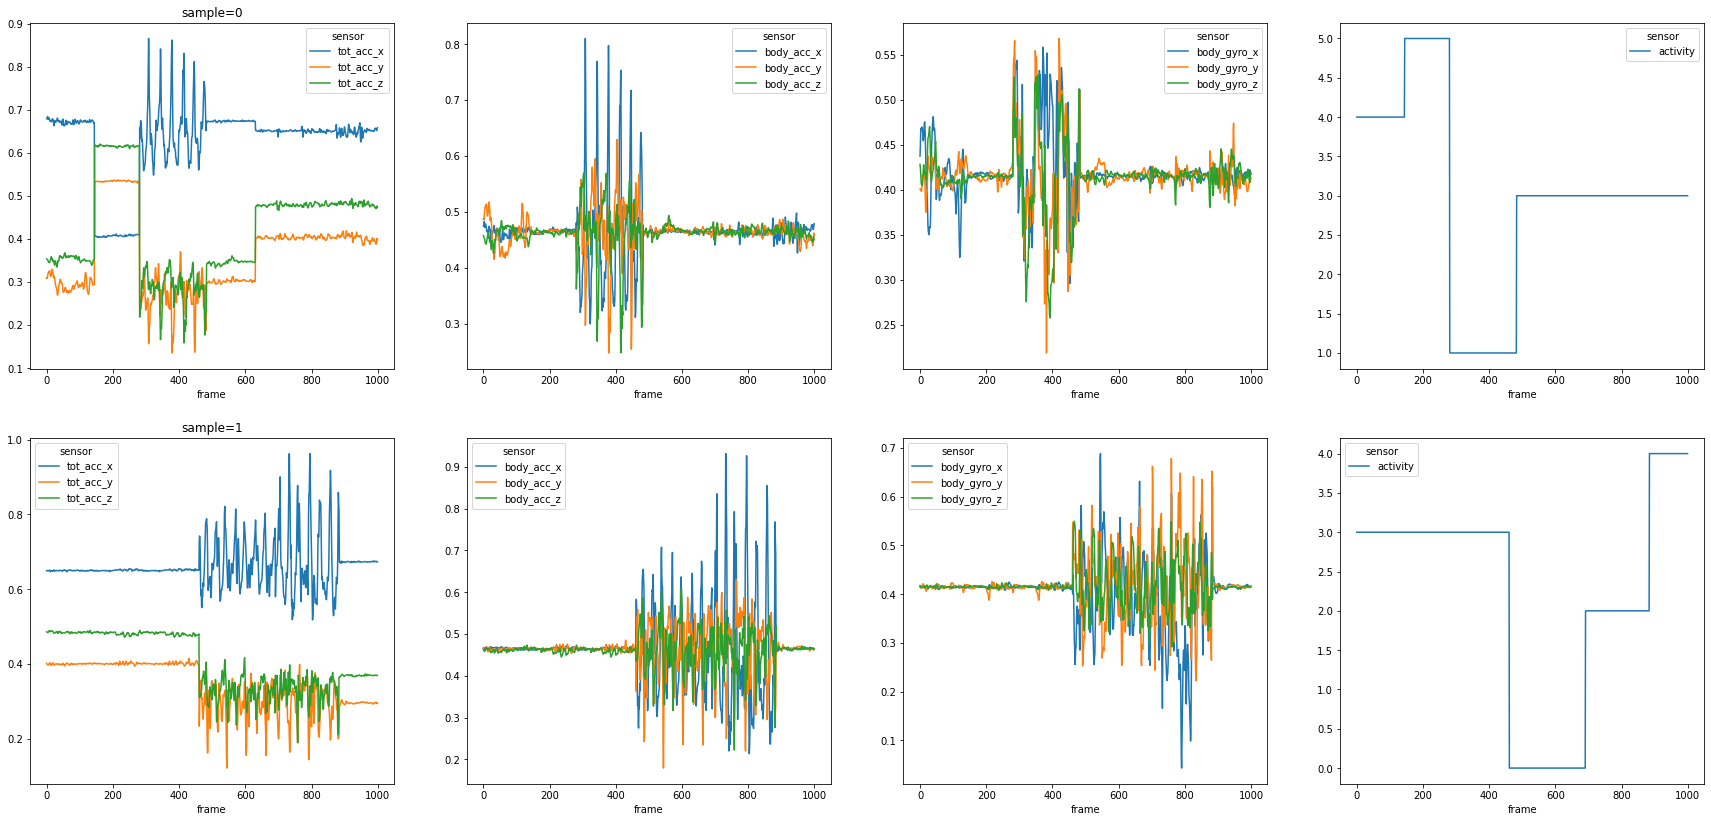

In [ ]:
def to_df(x, y):
    """
    Converts training/testing input features and corresponding labels into
    a Pandas Dataframe format
    
    Inputs:
    x: Input features (train or test) in numpy array format
    y: Targets/labels (train or test) in numpy array format
    
    Output:
    dataset_df: Train or test data, structered as a table with column names
    """
    
    numpy_data = np.concatenate([x,y], axis=2)
    
    dataset_df = xa.DataArray(numpy_data, 
                                     dims = ['N', 'frame', 'sensor'],
                                     name='training_data')\
                                        .to_dataframe()\
                                        .unstack('sensor')['training_data']\
                                        .reset_index()

    column_names = ['tot_acc_x', 'tot_acc_y', 'tot_acc_z', 'body_acc_x', 'body_acc_y',
       'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'activity']
    
    dataset_df = dataset_df.rename(columns = dict(zip(list(dataset_df.columns[2:]), 
                                                      column_names)))\
                                         .astype({'activity':int})

    return dataset_df



def plot_training_samples(N, dataset_df):
    """
    Plots samples in test/train dataset
    
    Inputs 
    N: Number of samples that will be visualised. 
    dataset_df: Train or test data, structered as a table with column names. 
                This tabular structured data can be obtained with `to_df` function.
    """
    
    f, axes = plt.subplots(N, 4, figsize=(30, N*7))
    axes = iter(axes)

    for pid, df_pid in list(dataset_df.groupby('N'))[:N]:

        ax_tot_acc, ax_body_acc, ax_body_gyro, ax_activity = tuple(next(axes))

        df_pid.plot(x = 'frame', y=['tot_acc_x','tot_acc_y', 'tot_acc_z'], title=f'sample={pid}', ax=ax_tot_acc)
        df_pid.plot(x = 'frame', y=['body_acc_x','body_acc_y', 'body_acc_z'], ax=ax_body_acc)
        df_pid.plot(x = 'frame', y=['body_gyro_x','body_gyro_y', 'body_gyro_z'], ax=ax_body_gyro)
        df_pid.plot(x = 'frame', y=['activity'], ax=ax_activity) 
        
    
    

training_data_df = to_df(train_x, train_y)

plot_training_samples(2, training_data_df);

In [ ]:
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).long()
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).long()

In [ ]:
train_ds = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_ds, batch_size=100)

test_ds = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_ds, batch_size=100)

In [ ]:
from torch import nn
import torch.nn.functional as F
class HTR(nn.Module):


    def __init__(self, n_features, lstm_dims, labels, bidirectional, hidden_out):
        super(HTR, self).__init__()
        self.lstm_dims = lstm_dims
        self.bidirectional = bidirectional
        if self.bidirectional:
          print("BID_LSTM")
          fully_connected_in = 2*self.lstm_dims
          fully_connected_out = 2*fully_connected_in
        else:
          fully_connected_in = self.lstm_dims
          fully_connected_out = 2*fully_connected_in
        
        # self.conv1 = nn.Conv1d(9, out_channels=32, kernel_size=5)
        # self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5)

        self.lstm1 = nn.LSTM(n_features, lstm_dims, num_layers = 2, bidirectional = self.bidirectional)
        self.f0 = nn.Linear(fully_connected_in, fully_connected_out)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.2)
        self.f1 = nn.Linear(fully_connected_out, labels)

    def forward(self, x):
      
        # print(x.size())
        # x = x.permute(1,0,2)
        # x = self.conv1(x)
        # x = self.conv2(x)
        h0 = self.lstm1(x)[0]
        # print("H0")
        # print(h0[2][1])
        # print(len(h0[2][1]))
        # print("After LSTM ", h0.size())
        # h0 = self.lstm2(h0)[0]
        output = self.f0(h0)
        output = self.relu(output)
        output = self.drop(output)
        output = self.f1(output)
        return output
       
    def init_hidden(self, x):
        # print(x.size)
        h0 = torch.zeros(self.lstm_dims, x.size(0), self.lstm_dims)

        # print(type(h0))
        c0 = torch.zeros(self.lstm_dims, x.size(0), self.lstm_dims)
        # print(type(c0))
        return [t.cuda() for t in (h0, c0)]

In [ ]:
class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 test_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.test_DataLoader = test_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self):

 
        total_correct, total_count = 0, 0
        test_correct, test_count = 0, 0

        train_acc, test_acc, train_loss, test_loss = 0,0,0,0


        log_interval = 500

        for epoch in (range(self.epochs)):
            
            start_time = time.time()

            self.model.train() 
  
            for idx, (x,y) in enumerate(self.training_DataLoader):
                input, target = x.to(self.device), y.view(100,1000).to(self.device)
                self.optimizer.zero_grad()
                out = self.model(input) 
                y_class = out.argmax(dim=2)

                loss = self.criterion(out.permute((0,2,1)), target) 
                loss_value = loss.item()
                # train_losses.append(loss_value)

                total_correct += (y_class == target).sum().item()
                total_count += target.size(0)*target.size(1)


                loss.backward() 
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                self.optimizer.step()


            train_acc = total_correct/total_count
            train_acc_plot.append(train_acc)
            train_loss = loss_value
            train_loss_plot.append(loss_value)

            self.model.eval()
            for idx, (x,y) in enumerate(self.test_DataLoader):
                input, target = x.to(self.device), y.view(100,1000).to(self.device)

                out = model(input)

                y_class_val = out.argmax(dim=2)

                loss = self.criterion(out.permute((0,2,1)), target)
                loss_value = loss.item()


                test_correct += (y_class_val == target).sum().item()
                test_count += target.size(0)*target.size(1)

            test_acc = test_correct/test_count
            test_acc_plot.append(test_acc)
            test_loss_plot.append(loss_value)
            test_loss = loss_value

            end_time = time.time()
            t_time = end_time - start_time
            # print('{} seconds'.format(time.time() - t0)
            print('| epoch {:3d} | Train accuracy {:8.3f} | Test accuracy {:8.3f} *\/\/* '
                  'Train loss {:8.3f} | Test loss {:8.3f} | Time/epoch {:8.3f}'.format(epoch+1, train_acc, test_acc, train_loss, test_loss,t_time))
            # print('| epoch {:3d} | Train loss {:8.3f} | Test loss {:8.3f}'.format(epoch+1, train_loss, test_loss))
            train_acc, test_acc, train_loss, test_loss = 0, 0, 0, 0
            test_correct, test_count = 0, 0



In [ ]:
from torchsummary import summary

features = 9
lstm_dims = 64
hidden_layer_input = 256
labels = 6

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

train_acc_plot, test_acc_plot = [], []
train_loss_plot, test_loss_plot = [], []

model = HTR(features, lstm_dims, labels, True, hidden_layer_input)
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=train_loader,
                  test_DataLoader=test_loader,
                  epochs=50)

# start training
trainer.run_trainer()

BID_LSTM
HTR(
  (lstm1): LSTM(9, 64, num_layers=2, bidirectional=True)
  (f0): Linear(in_features=128, out_features=256, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.2, inplace=False)
  (f1): Linear(in_features=256, out_features=6, bias=True)
)
| epoch   1 | Train accuracy    0.418 | Test accuracy    0.596 *\/\/* Train loss    0.965 | Test loss    0.994 | Time/epoch   10.099
| epoch   2 | Train accuracy    0.494 | Test accuracy    0.666 *\/\/* Train loss    0.940 | Test loss    0.873 | Time/epoch    9.799
| epoch   3 | Train accuracy    0.543 | Test accuracy    0.638 *\/\/* Train loss    0.786 | Test loss    0.924 | Time/epoch    9.794
| epoch   4 | Train accuracy    0.569 | Test accuracy    0.639 *\/\/* Train loss    0.877 | Test loss    0.985 | Time/epoch    9.782
| epoch   5 | Train accuracy    0.584 | Test accuracy    0.655 *\/\/* Train loss    0.833 | Test loss    0.942 | Time/epoch    9.784
| epoch   6 | Train accuracy    0.600 | Test accuracy    0.677 *\/\/* Train loss    0

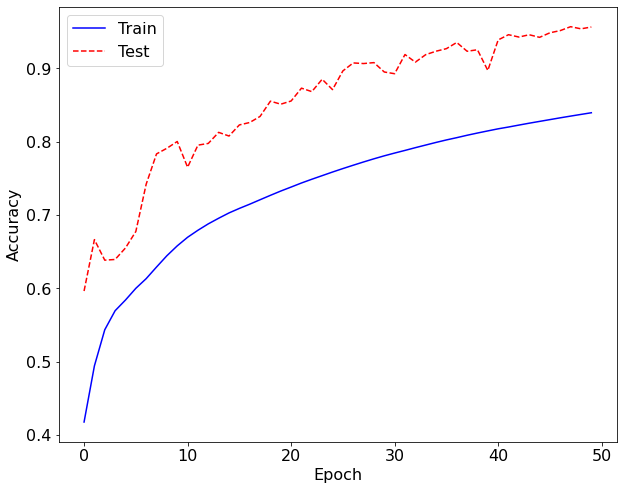

In [ ]:
f, ax = plt.subplots(1,1, figsize=(10,8))


fnt=16
ax.plot(train_acc_plot, color='blue', label='Train')
ax.plot(test_acc_plot, color='red', linestyle='--', label='Test')
ax.legend(fontsize=fnt)
ax.tick_params(axis='both', labelsize=fnt)

ax.set_xlabel("Epoch", fontsize=fnt)
ax.set_ylabel("Accuracy", fontsize=fnt);


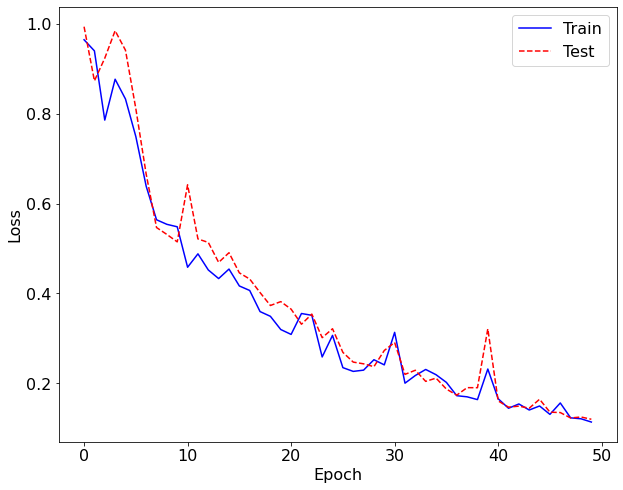

In [ ]:
f, ax = plt.subplots(1,1, figsize=(10,8))


fnt=16
ax.plot(train_loss_plot, color='blue', label='Train')
ax.plot(test_loss_plot, color='red', linestyle='--', label='Test')
ax.legend(fontsize=fnt)
ax.tick_params(axis='both', labelsize=fnt)

ax.set_xlabel("Epoch", fontsize=fnt)
ax.set_ylabel("Loss", fontsize=fnt);